# CNN features visualization

We are aiming at training a convolutional neural network (CNN) to recognize mode of action (MoA) of chemical compound from cell microscopy images taken after treatment with these compounds. We will use transfer learning, importing a pre-trained CNN: Inception v3. As a first attempt, we tried to freeze all layers of the model, and only retrain the last fully connected layer, on our new dataset. This resulted in slow and suboptimal loss decay. In order to optimize our model training, we therefore will unfreeze the last convolutional layers of the CNN, and finetune them on our dataset.

We will therefore now attempt to identify which layers we want to retrain on our dataset. To achieve this, we want to visualize examples of the features that are detected by each layer. We will then keep the high level ones (edges), as they will be applicable to our cell images dataset. However, the layers identifiying too specific features (like the eye of a cat, or the shape of a house) will be retrained in order to adapt them to our dataset.

In [7]:
# Let's first import the packages we will require
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
import cv2


In [3]:
# Load the pre-trained Inception V3 model
model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)
model.eval();

Let's now load and pre-process an input image, and then define a function to visualize the feature of a layer of the CNN. 
. Inception v3 is originally designed to recognize a variety of objects, among which everyday objects like animals or vehicles, but also medical images. Let's start with an image of a cat. 


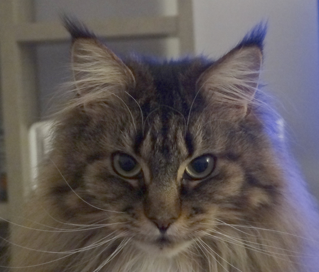

In [4]:
path = 'images/2016-02-01_08-14-24.jpg'
# Load the image
image = Image.open(path)

# Display the image
display(image.resize(( int(image.width * .1), int(image.height * .1))))


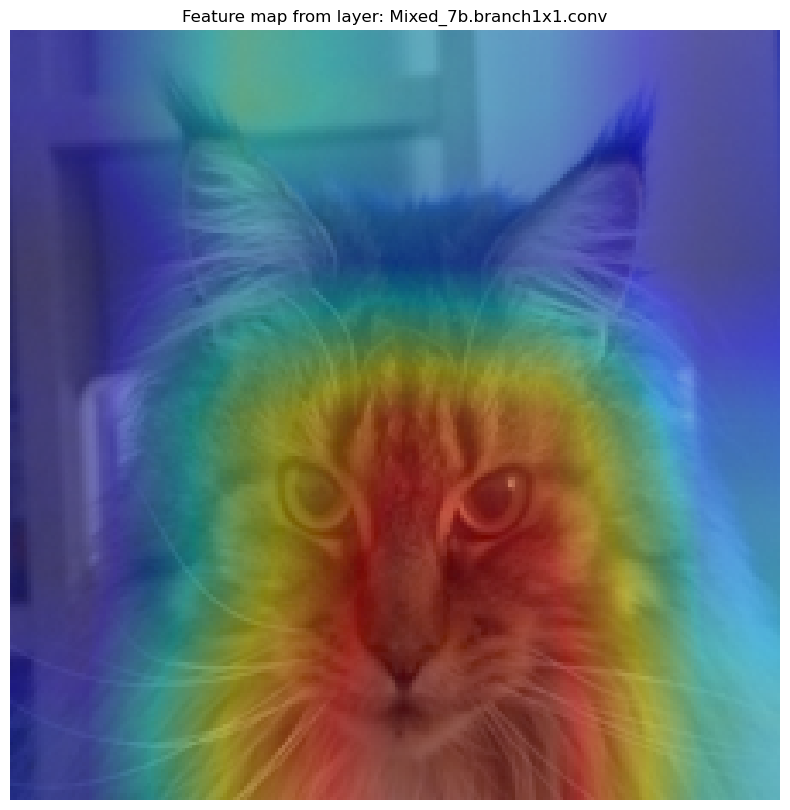

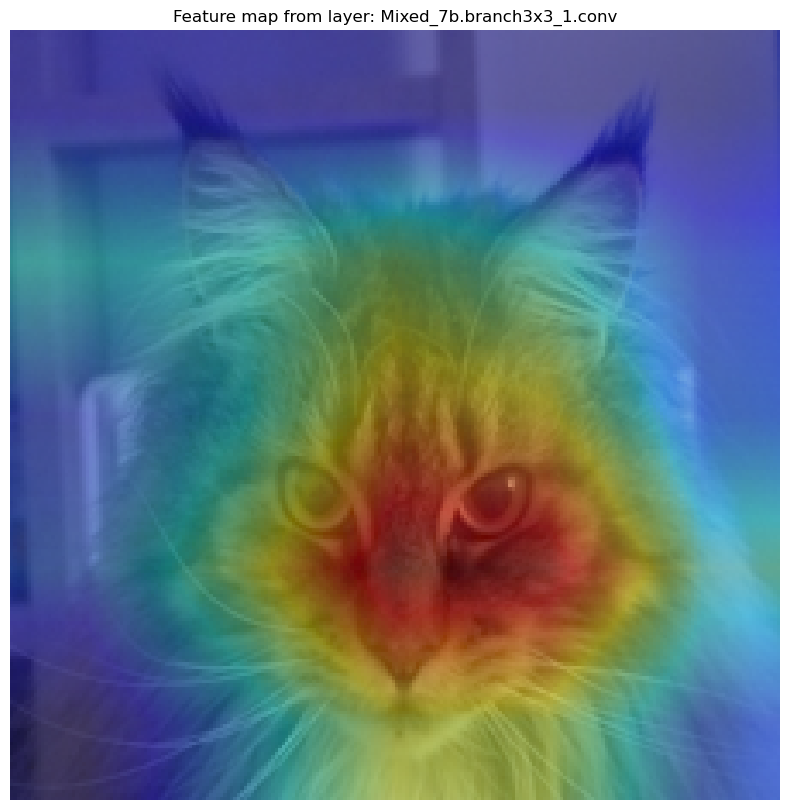

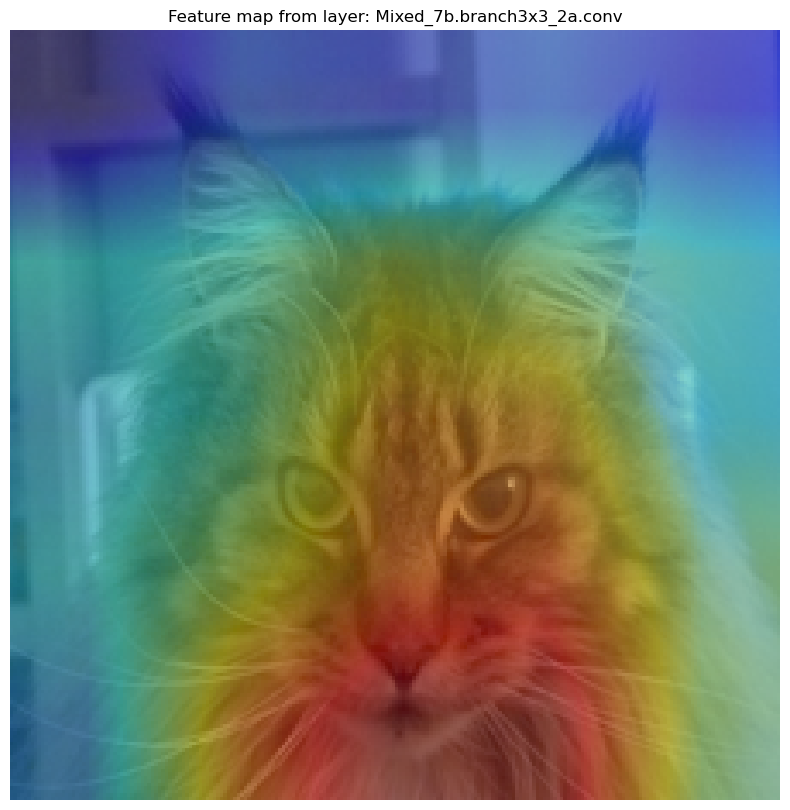

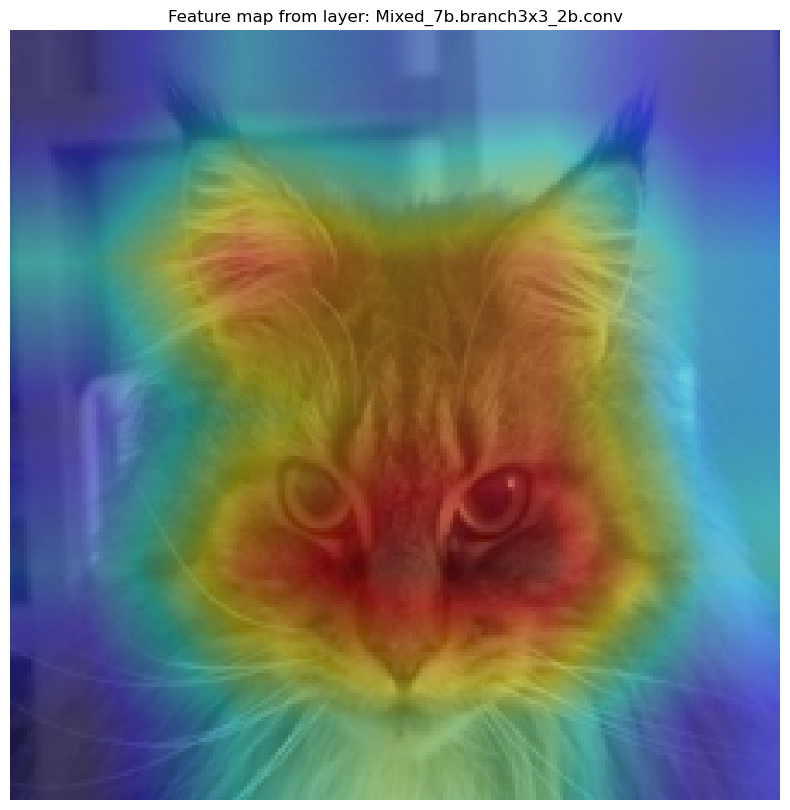

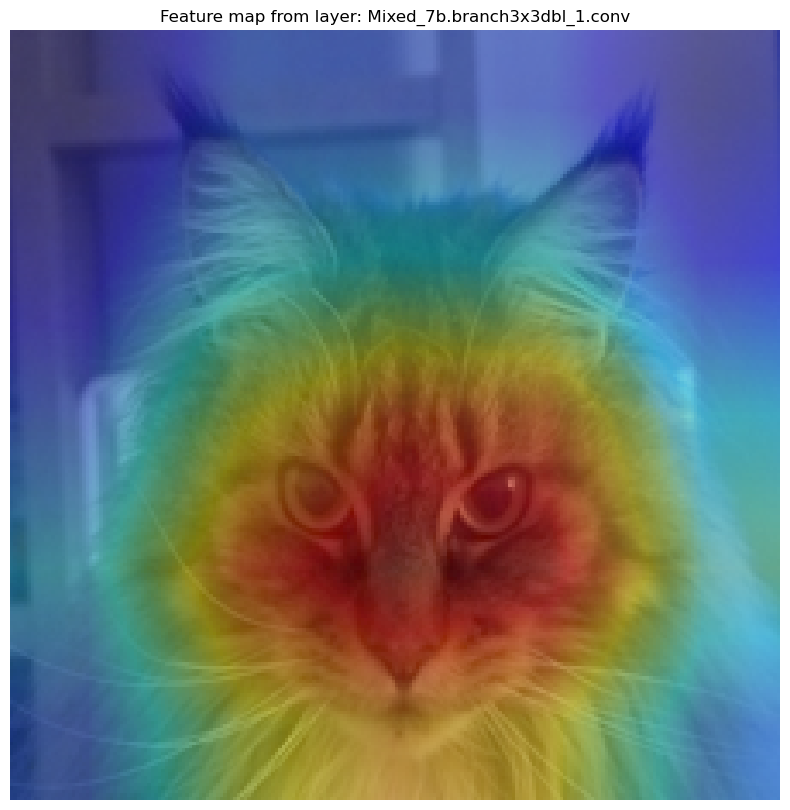

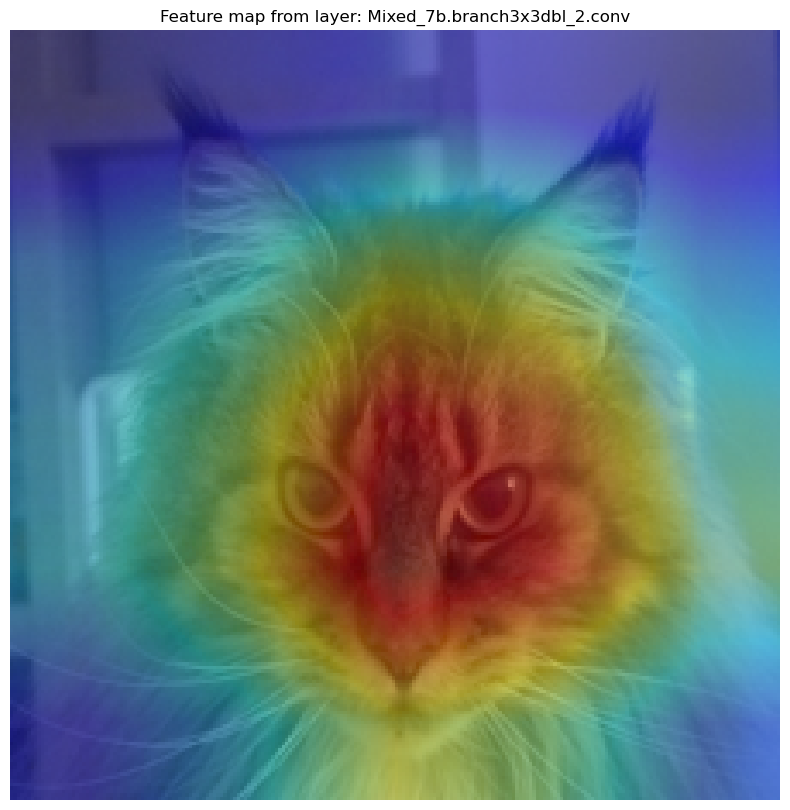

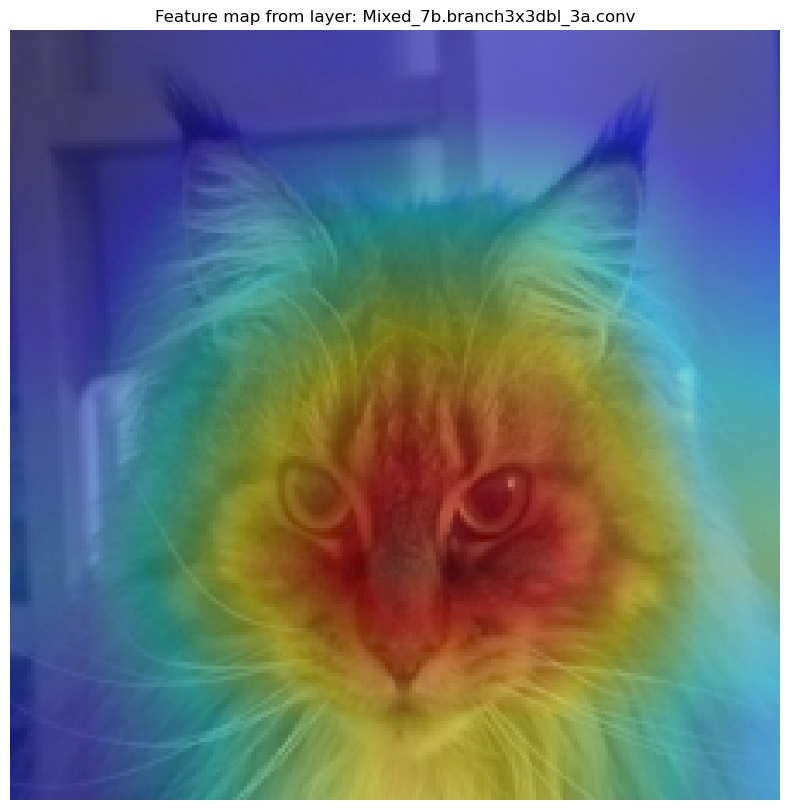

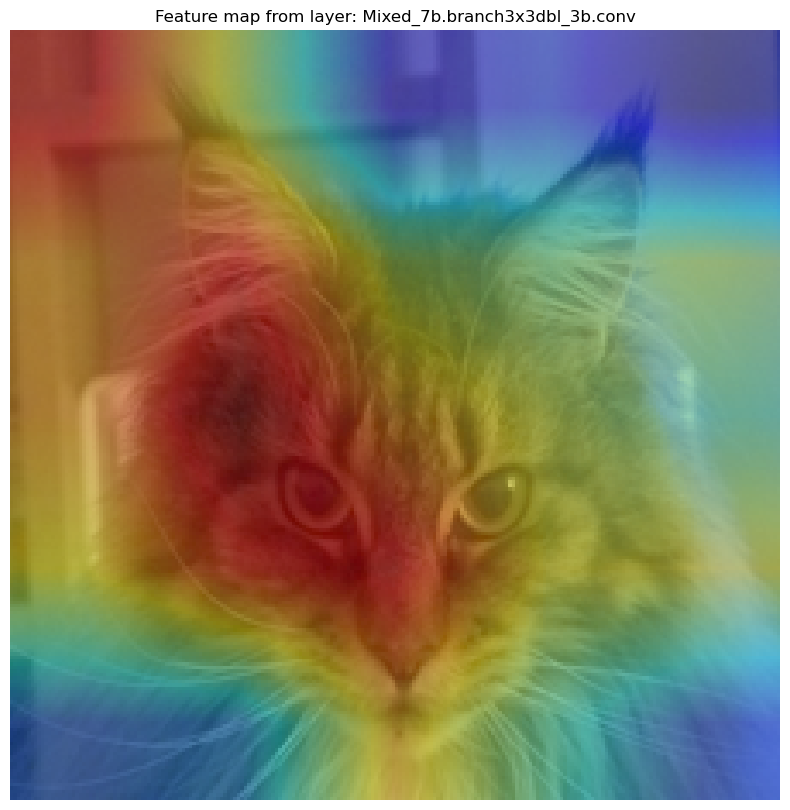

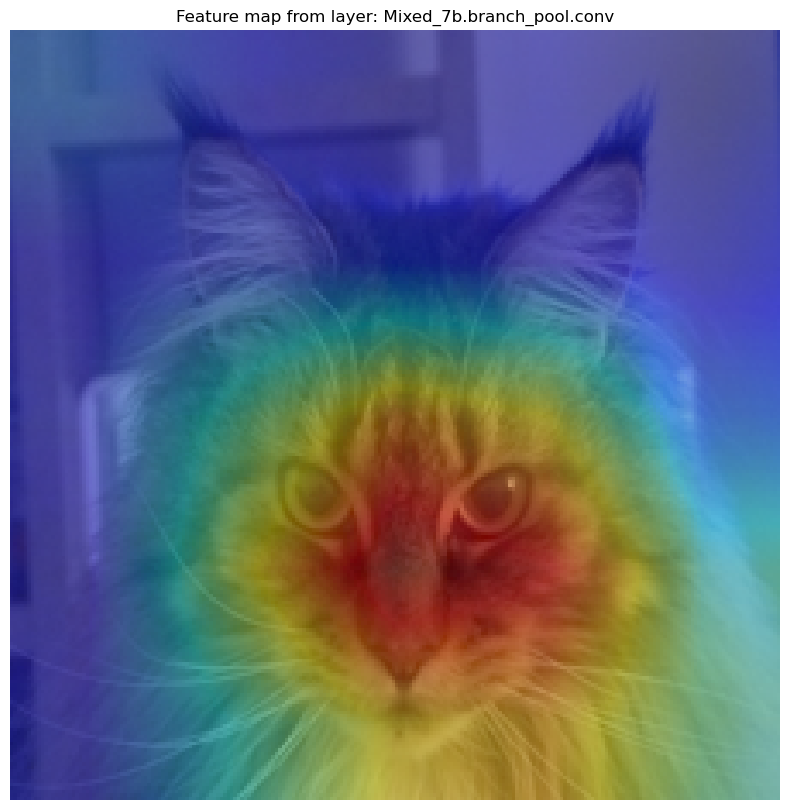

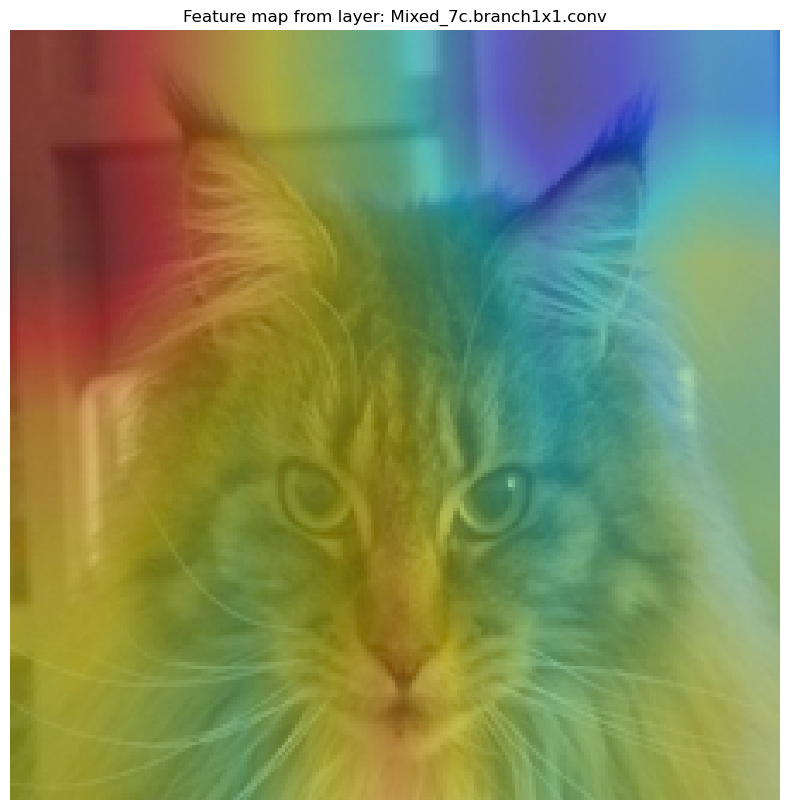

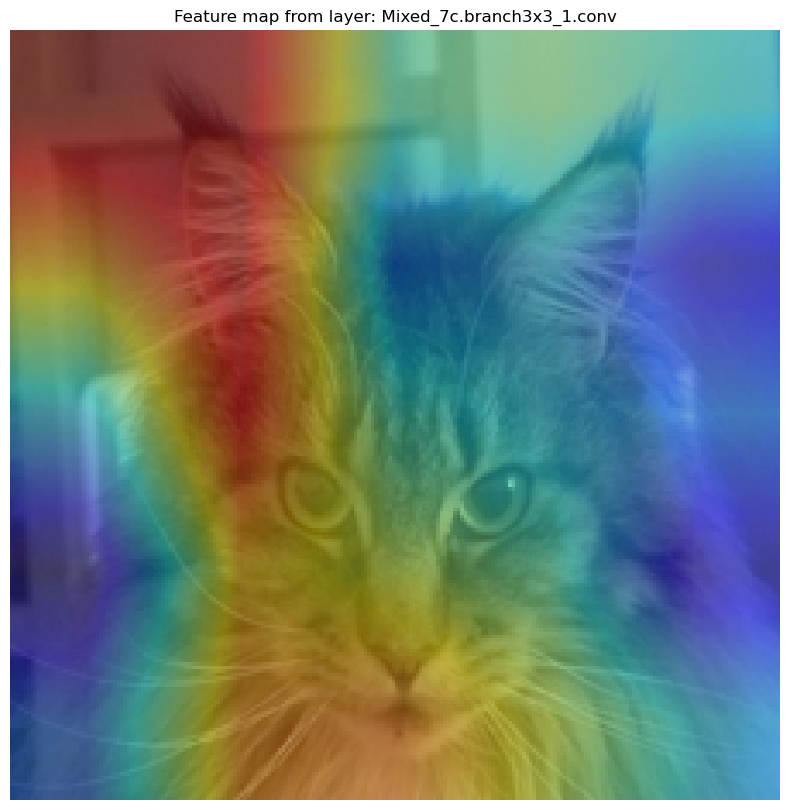

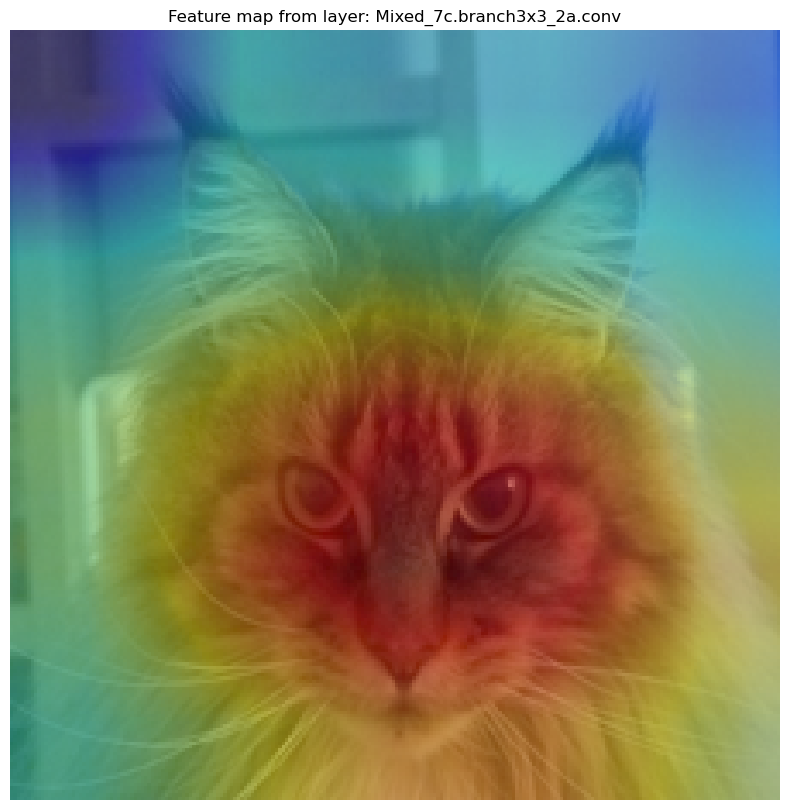

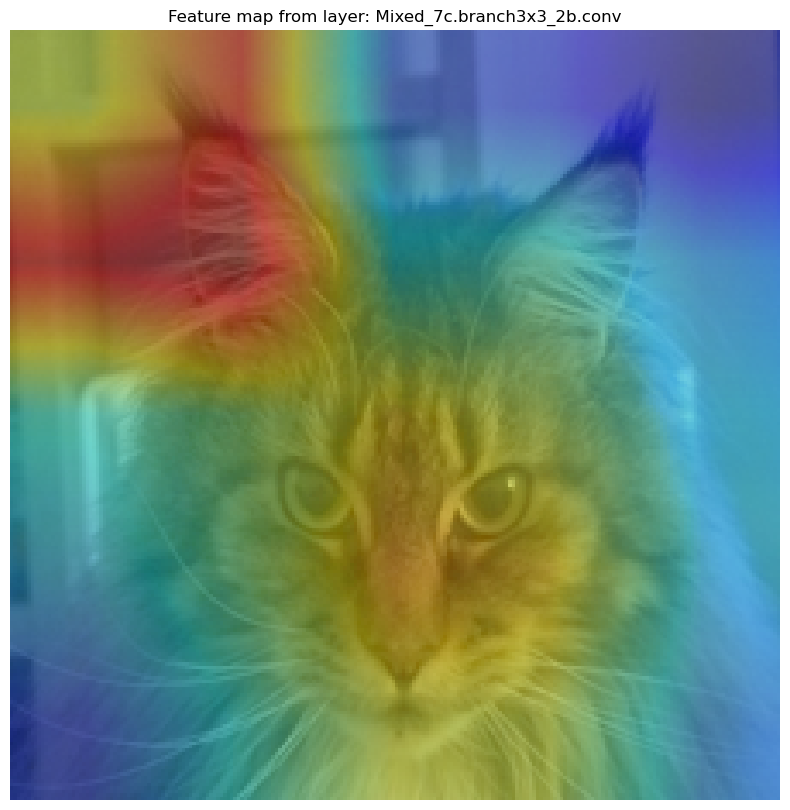

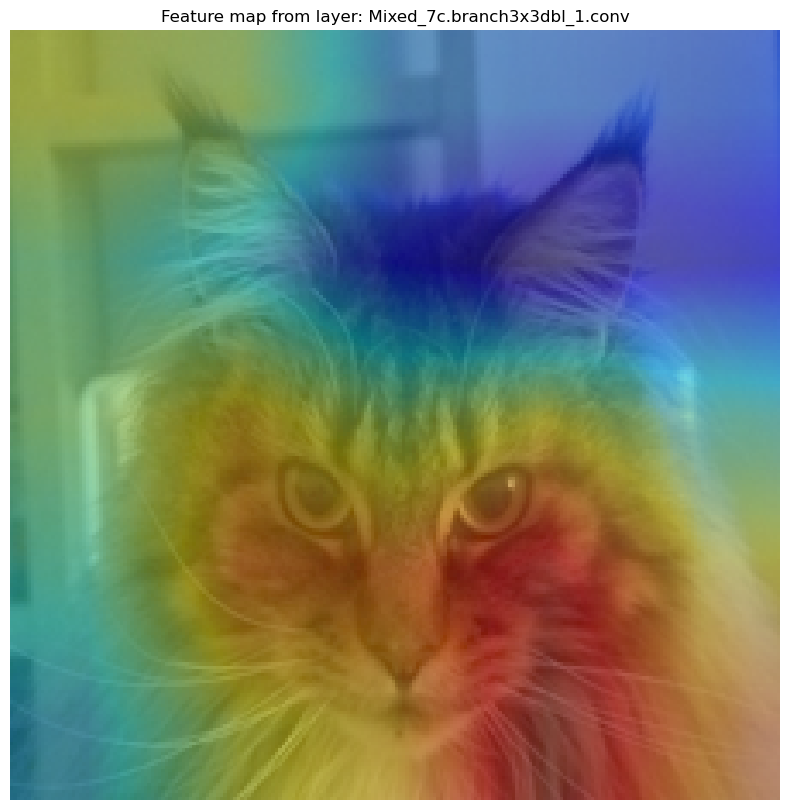

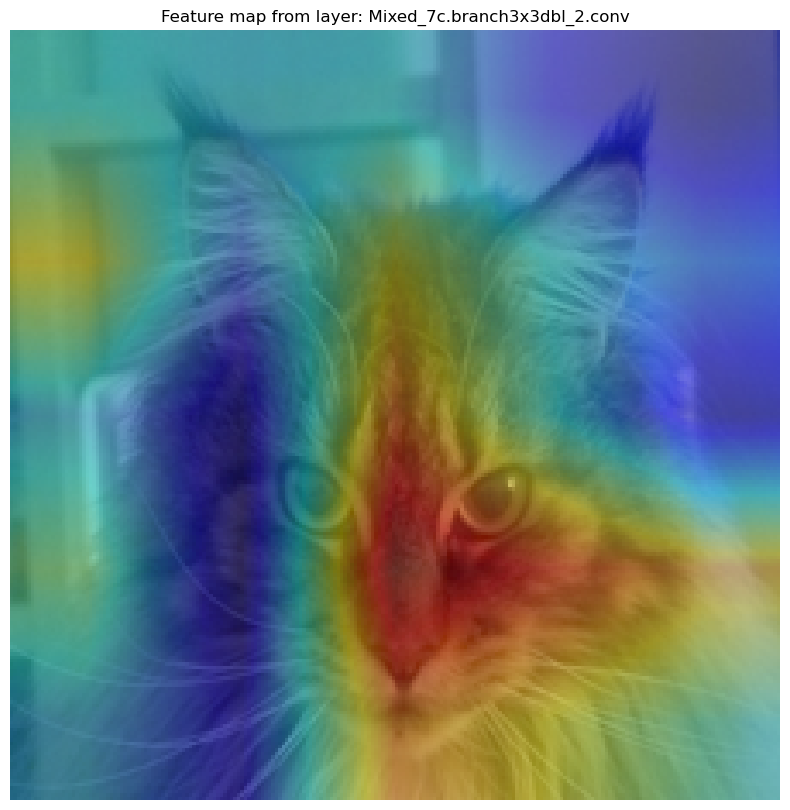

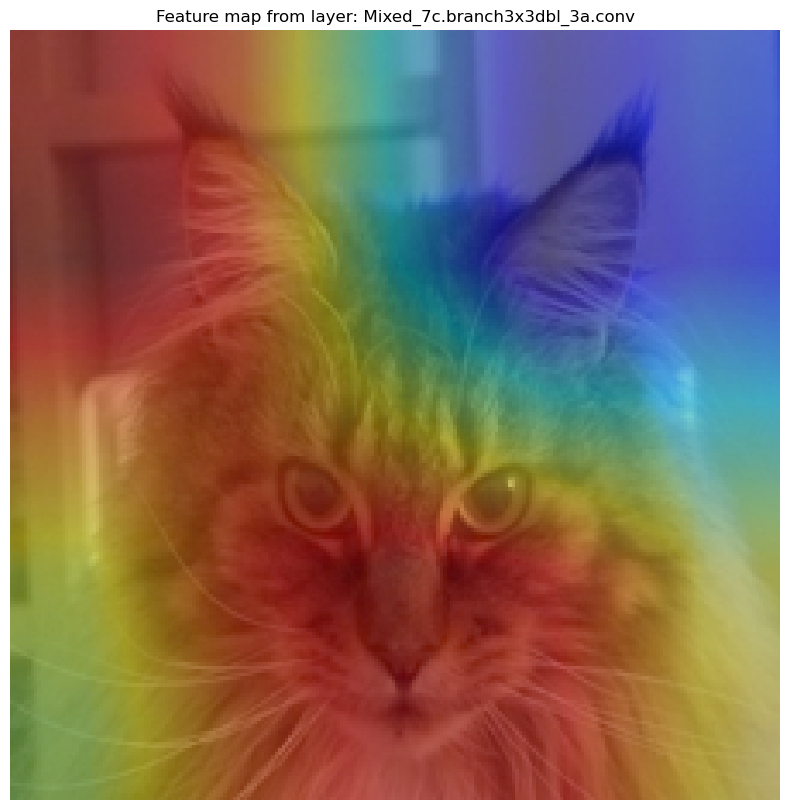

In [5]:
def visualize_features(path, filter_layers = 0, save = False):
    """Pre-processes the image located at the passed path, and visualizes the feature maps of each conv layer"""
    # Load and preprocess the cat image
    input_image = Image.open(path)
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)
    
    #define two lists to capture the feature maps, and the names of respective layer
    features = []
    names = []
    
    # Define a hook function to capture the outputs
    def hook_fn(module, input, output):
        features.append(output)
    
    
    # Register hooks to the desired layers
    for name, layer in model.named_modules():
        
        if isinstance(layer, torch.nn.Conv2d):
            layer.register_forward_hook(hook_fn)
            names.append(name)
            
    
    # Pass the image through the model
    with torch.no_grad():
        _ = model(input_batch)

    # Convert the original image to a numpy array
    img_np = np.array(input_image.resize((224, 224)))

    # Visualize the features
    for i, feature in enumerate(features[filter_layers:]):
        i += len(features) - 16
        feature = feature.detach()
        feature = feature.squeeze()
        
        # Average the feature map across the channels
        feature = feature.mean(dim=0)
        
        # Normalize the feature map
        feature = (feature - feature.min()) / (feature.max() - feature.min())

        # Resize the feature map to match the input image size
        feature = F.interpolate(feature.unsqueeze(0).unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False).squeeze()
        
        # Convert the feature map to a numpy array
        feature = feature.numpy()
        # Convert the feature map to a 3-channel image
        feature = cv2.applyColorMap(np.uint8(255 * feature), cv2.COLORMAP_JET)
        
        # Blend the feature map with the original image
        blended = cv2.addWeighted(img_np, 0.6, feature, 0.4, 0)

         # Ensure the input image is in the correct format
        if img_np.dtype != np.uint8:
            img_np = img_np.astype(np.uint8)
            
        # Display the blended image
        plt.figure(figsize=(10, 10))
        plt.imshow(blended)
        plt.axis('off')
        plt.title(f'Feature map from layer: {names[i]}')
        plt.show()

        #save the image
        if save:
            im = Image.fromarray(blended)
            im.save("images/{}.jpeg".format(names[i]))
       

visualize_features(path, -30, save = True)

It seems that layers named "Mixed_7b" and "Mixed_7c" are really recognizing low level features, like the face of the cat, her ears, or eyes. It is also true to some extent for layer "Mixed_7a", but this one seems to capture slightly higher level features. From layer "Mixed_6e" and above, it is clear that features captures are much higher level, and rather complex combination of edges that could potentially apply to other animals, than cat specific features. Let's confirm this observation with another picture, this time we will test it on a lighthouse picture.



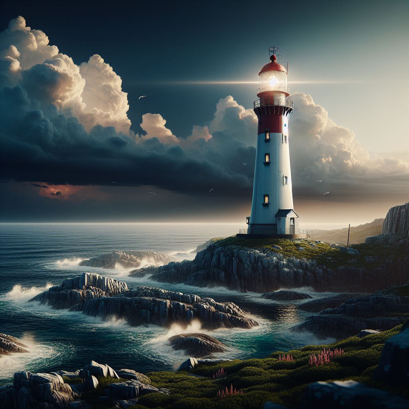

In [52]:
path = 'images/lighthouse.jpeg'
# Load the image
image = Image.open(path)

# Display the image
display(image.resize(( int(image.width * .4), int(image.height * .4))))


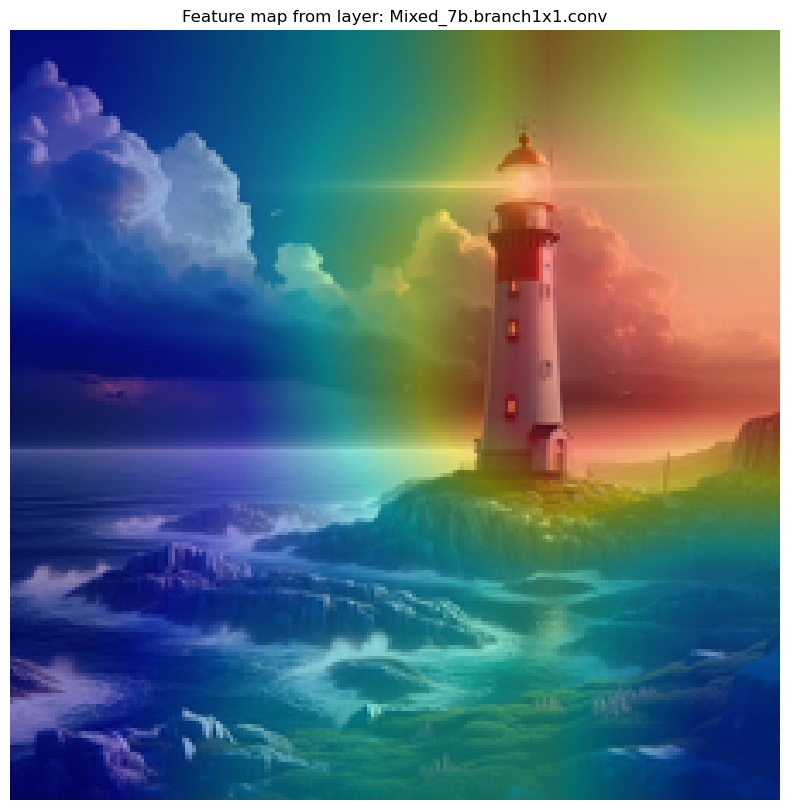

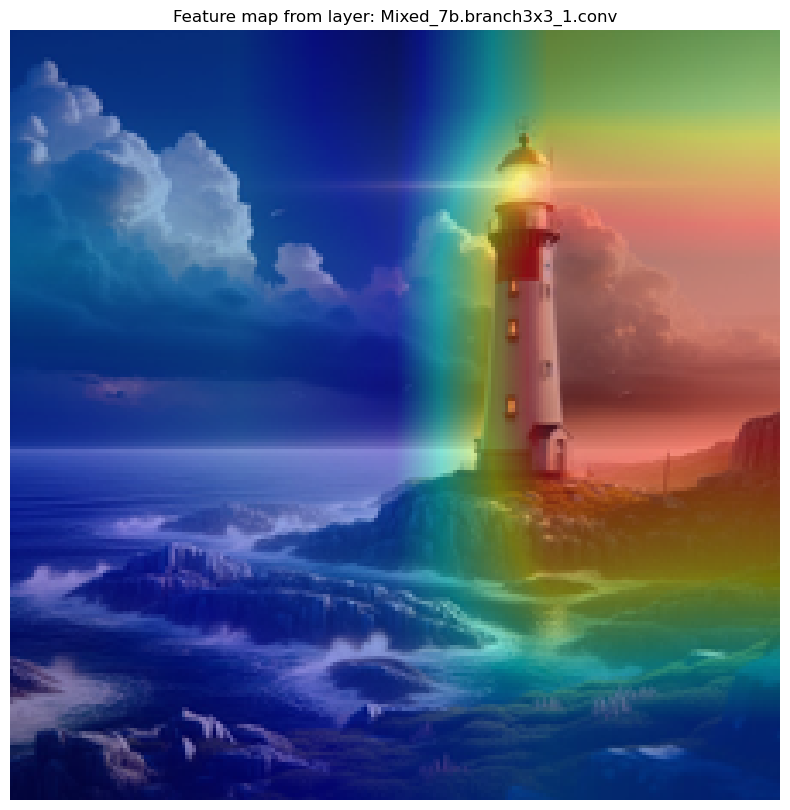

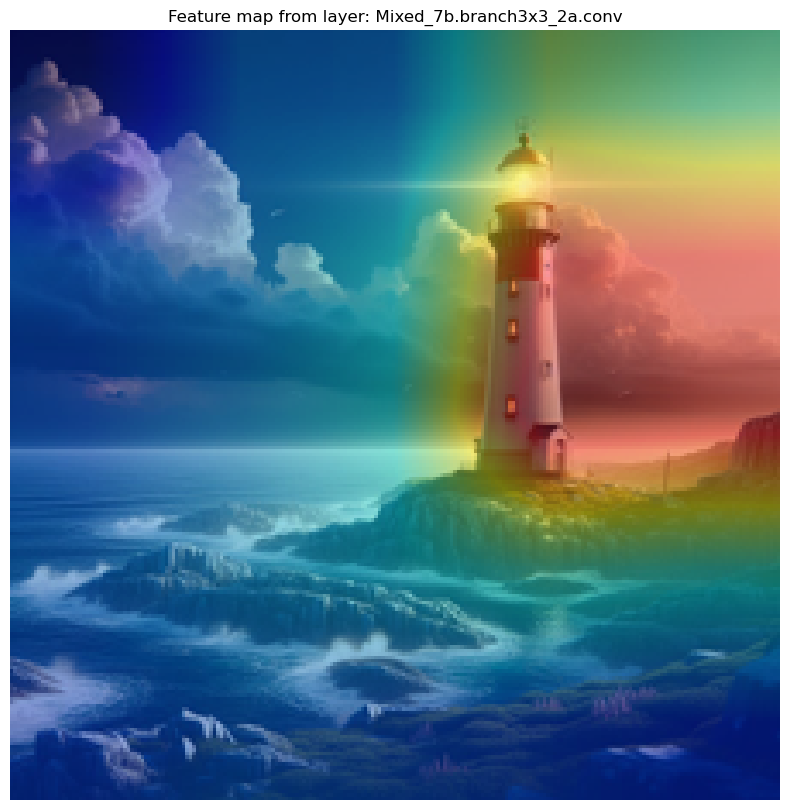

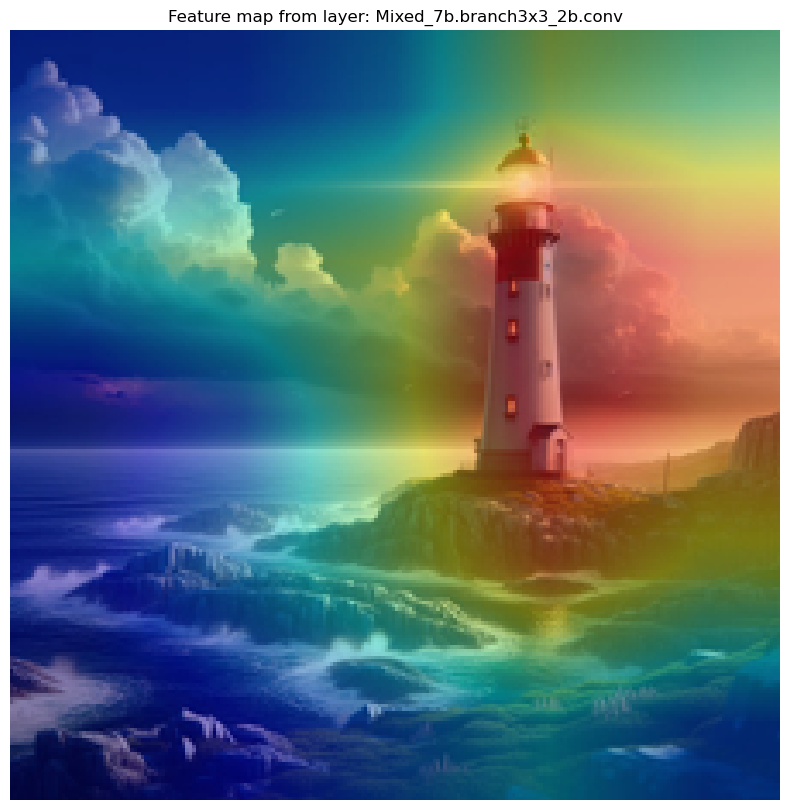

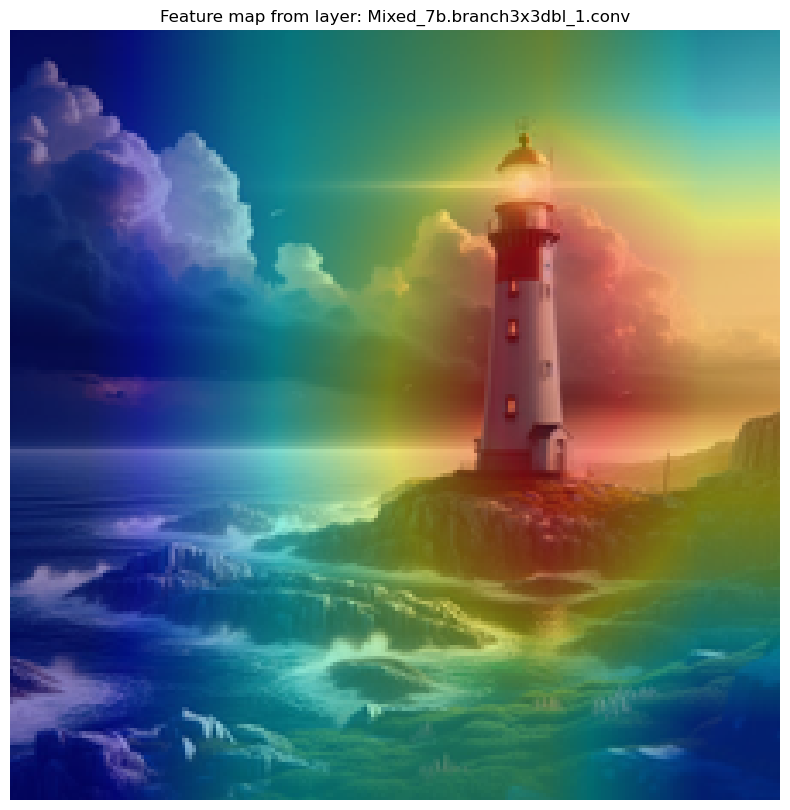

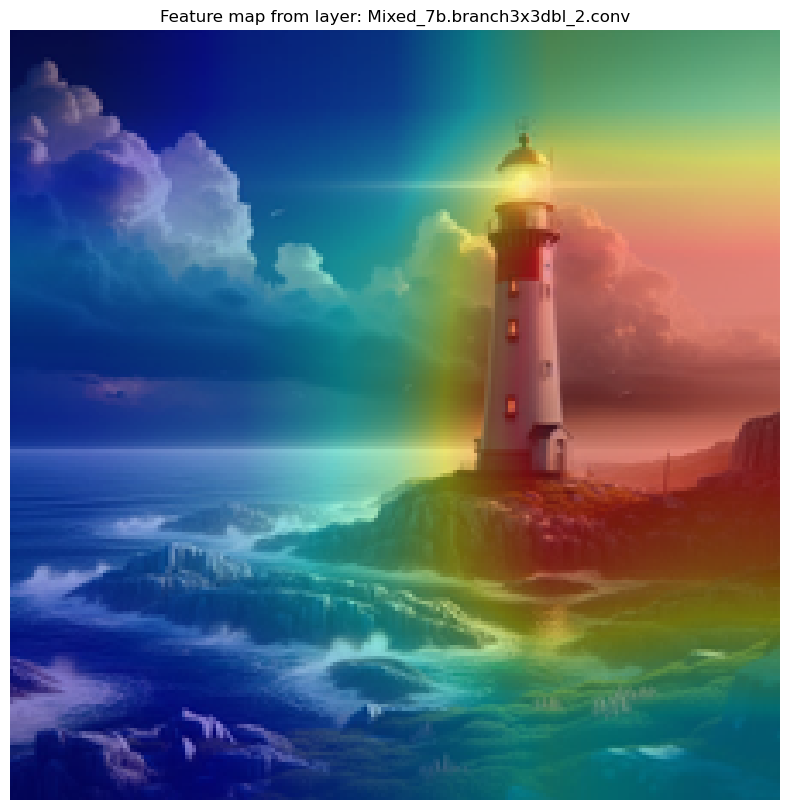

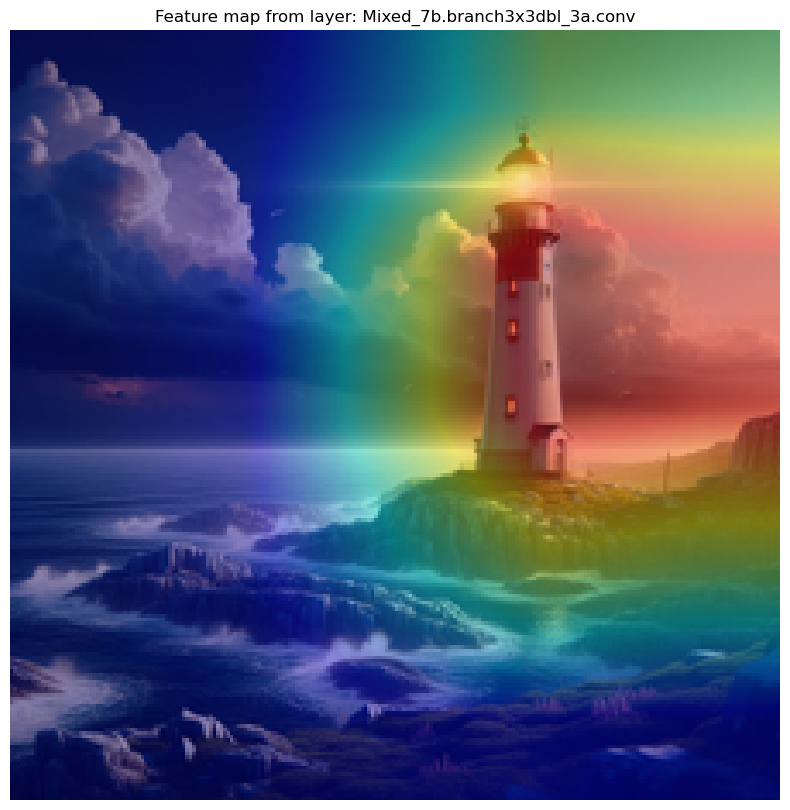

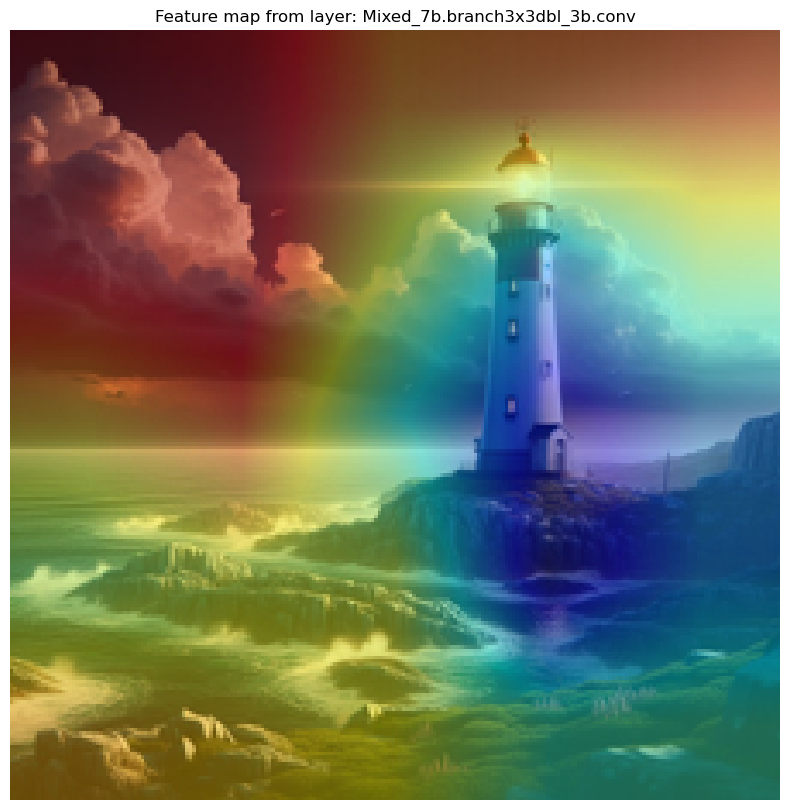

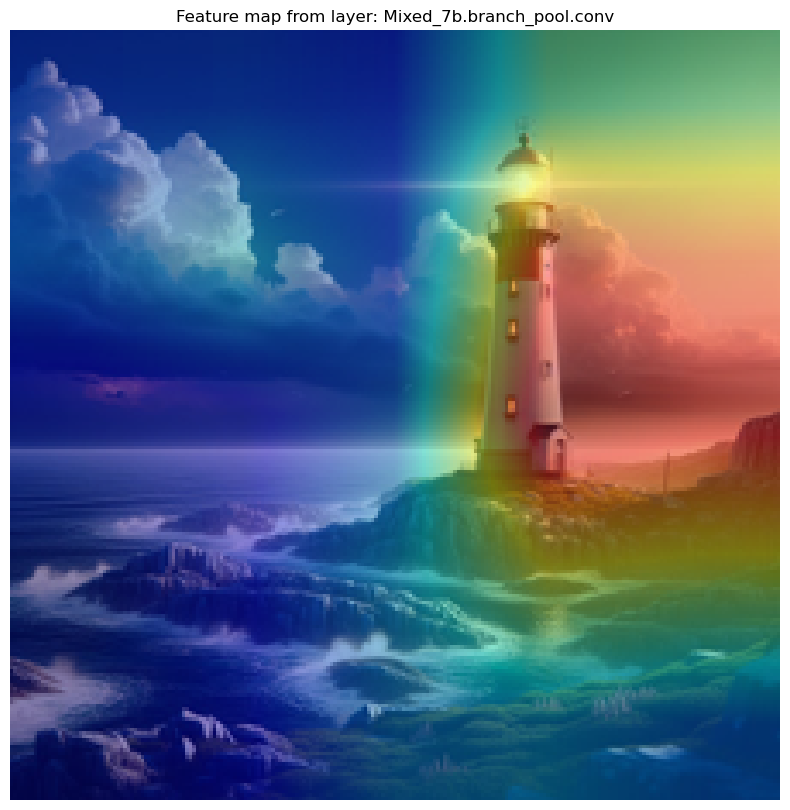

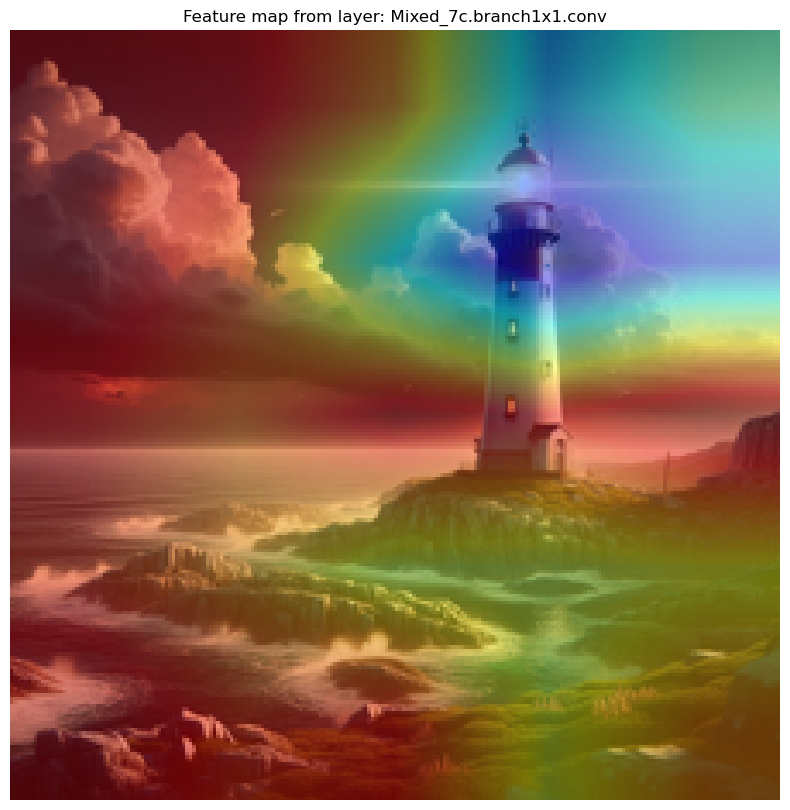

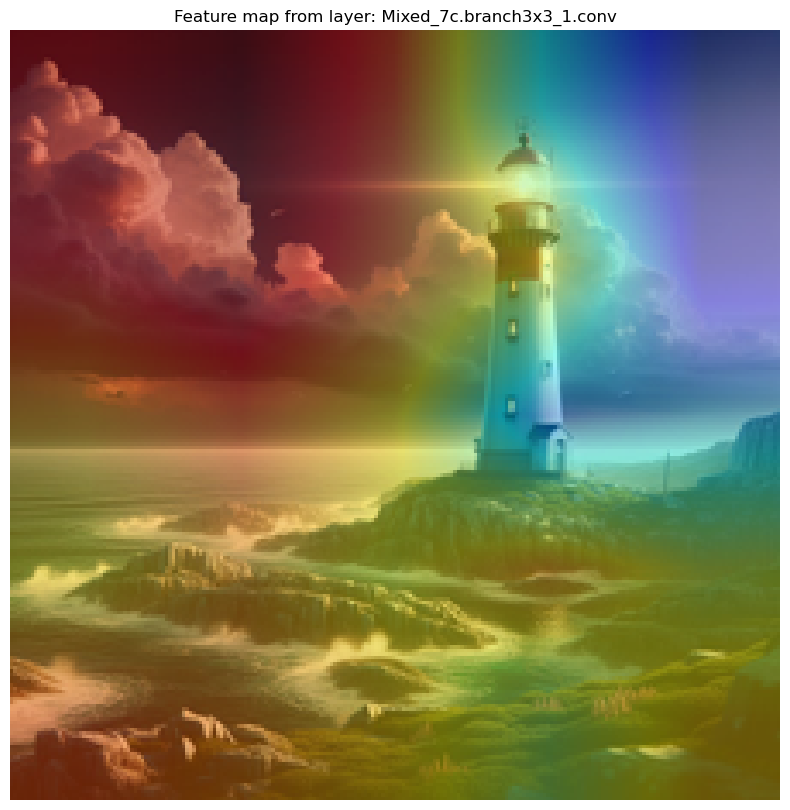

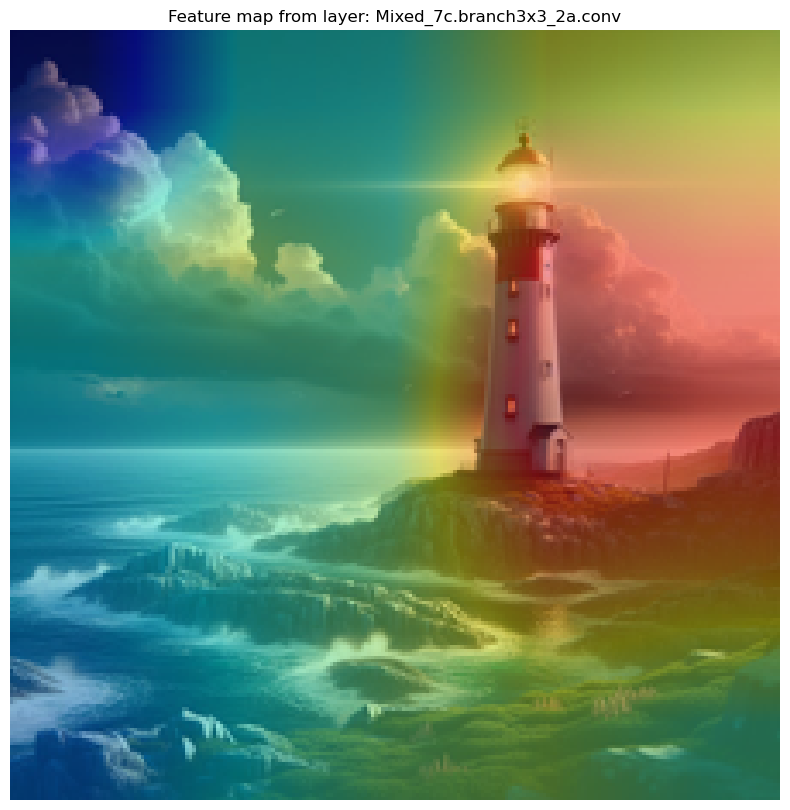

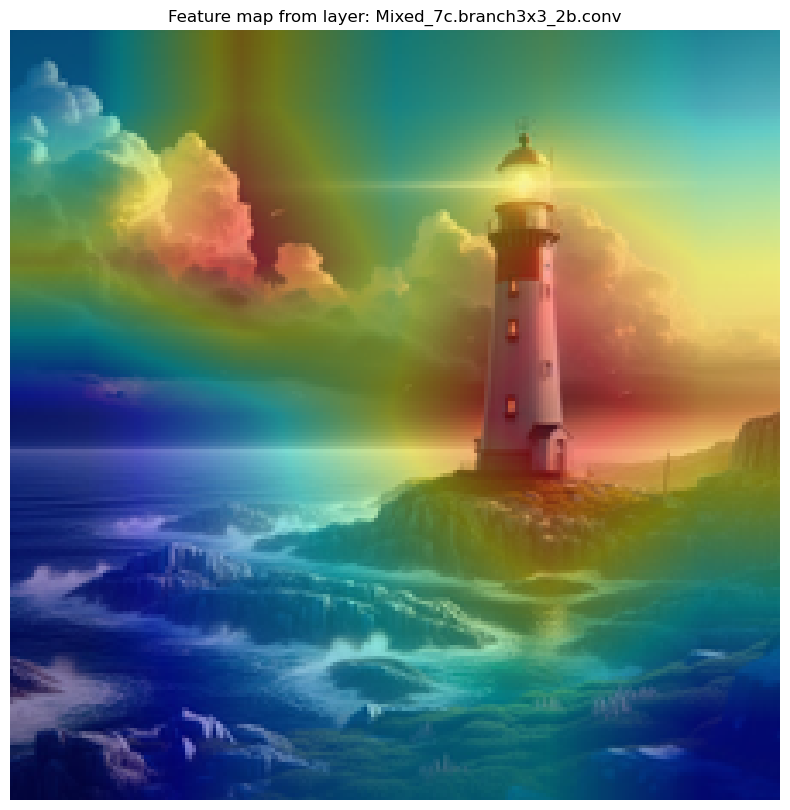

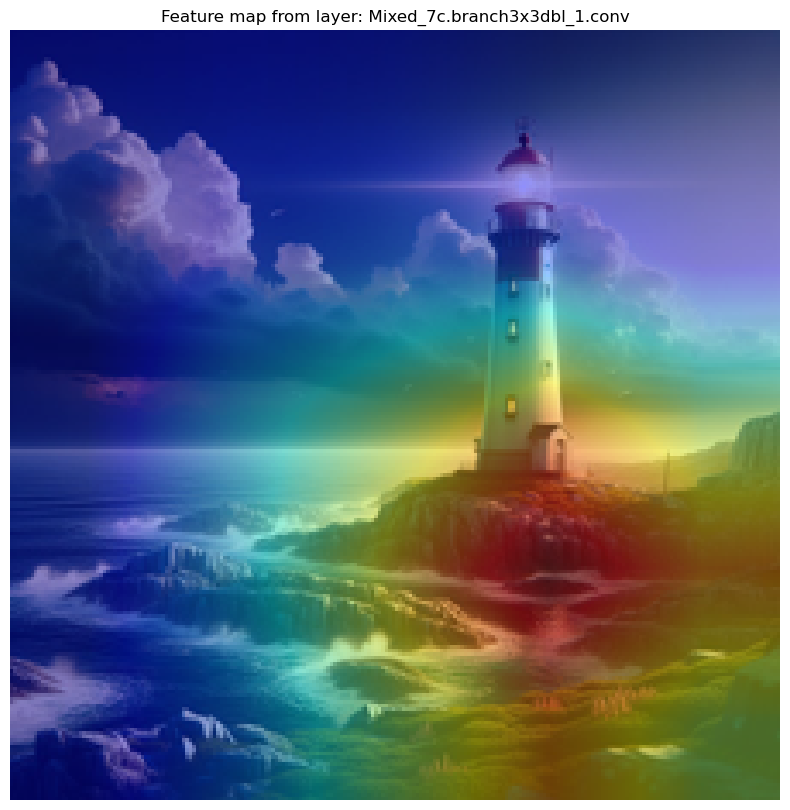

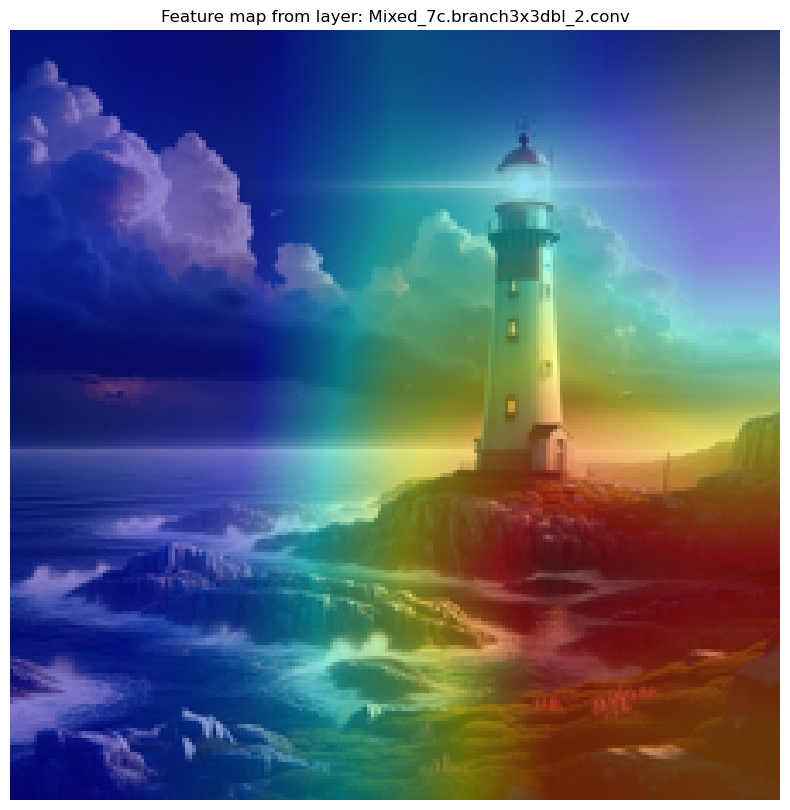

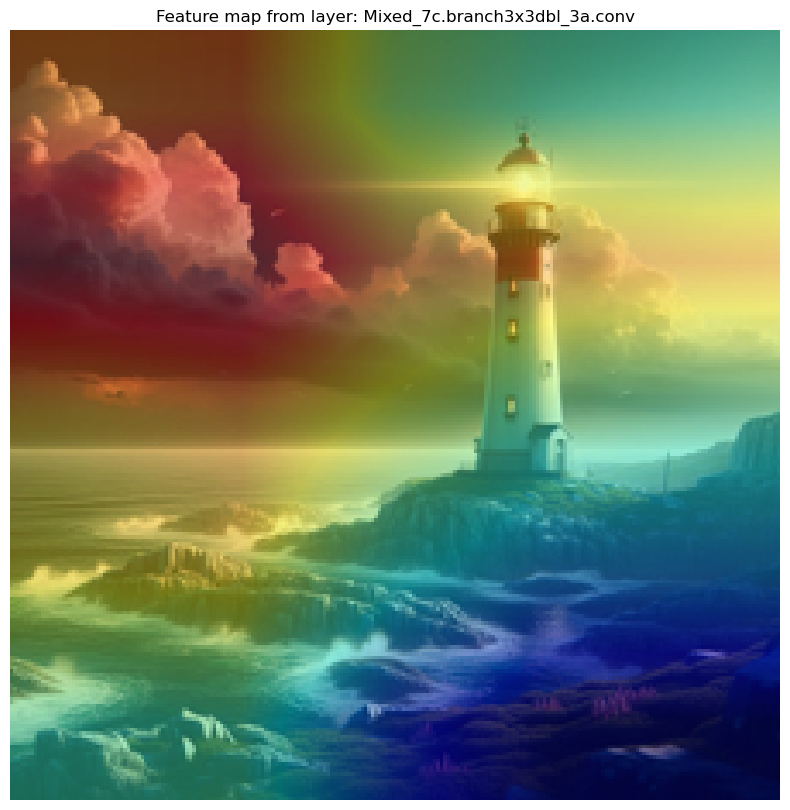

In [53]:
visualize_features(path, -16, save = True)

Here again, "Mixed_7b" and "Mixed_7c", are recognizing the lighthouse as whole, or the clouds/scenery. This confirms that these layers recognize the final objects that are then classified into the 1000 classes that inception v3 can natively recognize. It would probably be beneficial to retrain these two layers, so they can learn the shapes of the cells, or of the nucleus, that are specific to the MoAs we want to classify. Out of curiosity, let's try to load one of our dataset images, to see what our raw model captures there.

Our cell microscopy images consist in three channels: DAPI, Tubulin, and Actin. Those are different cell component that get coloured by different dyes before acquiring the image. The microscope capture device has a filter that captures a single one of these dyes, explaining why each image is acquired with three channels separately. We therefore need to reconstitute our image first, before we can display it. 

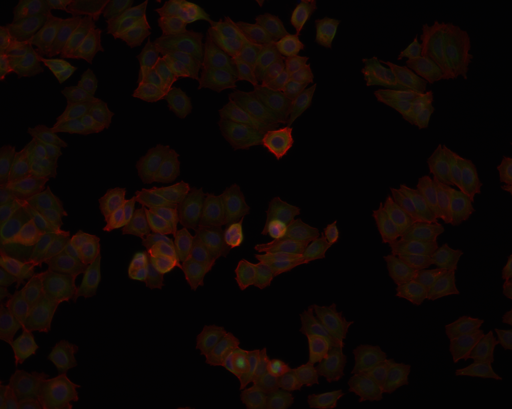

In [19]:
root_dir = 'sorted_reduced/train/'
cls = 'Actin disruptors'

a_path = os.path.join(root_dir, cls, 'actin', 'img0.tif')
t_path = os.path.join(root_dir, cls, 'tubulin', 'img0.tif')
d_path = os.path.join(root_dir, cls, 'dapi', 'img0.tif')

  
a_img = Image.open(a_path)
t_img = Image.open(t_path)
d_img = Image.open(d_path)



# # Normalize pixel values from 0-65535 to 0-255
a_img = a_img.point(lambda p: p * (255.0 / 65535.0))
t_img = t_img.point(lambda p: p * (255.0 / 65535.0))
d_img = d_img.point(lambda p: p * (255.0 / 65535.0))

# Convert images to grayscale
a_img = a_img.convert('L')
t_img = t_img.convert('L')
d_img = d_img.convert('L')
        
image = Image.merge('RGB', (a_img, t_img, d_img))

# Display the image
display(image.resize(( int(image.width * .4), int(image.height * .4))))

#save the image

image.save("images/example_cell_img.jpeg")

Note that the colours were arbitrarily represented as RGB, but they do not represent the actual colours of the cell images. The three channels in our image dataset should not be understood as RGB, but as three distinct components of the cells (actin, tubulin, and DAPI) that are artificially dyied before acquiring grayscale pictures. 

Let's now see what our native inception v3 CNN detects in this picture.

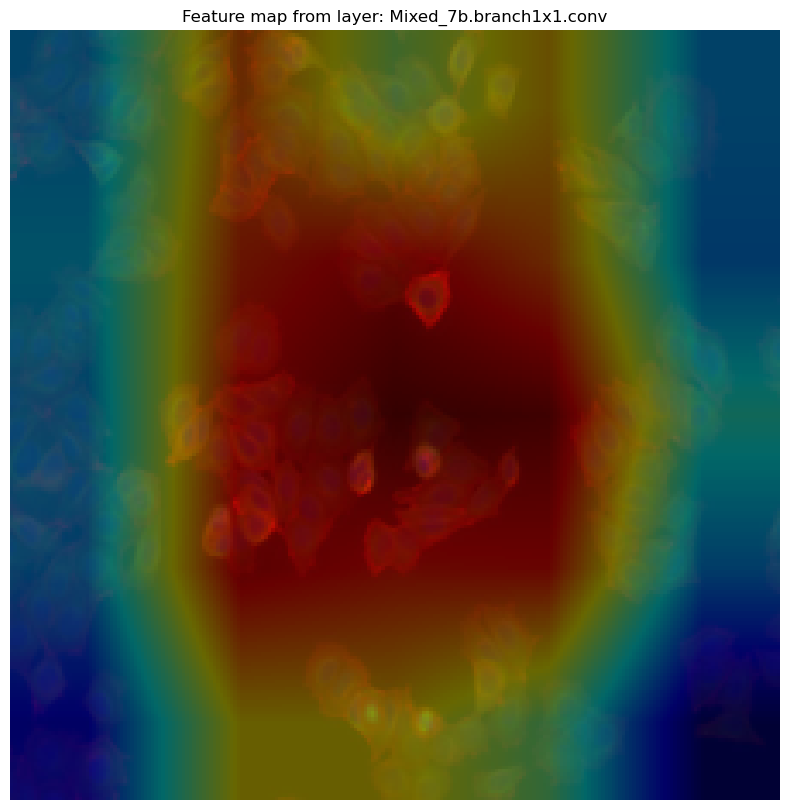

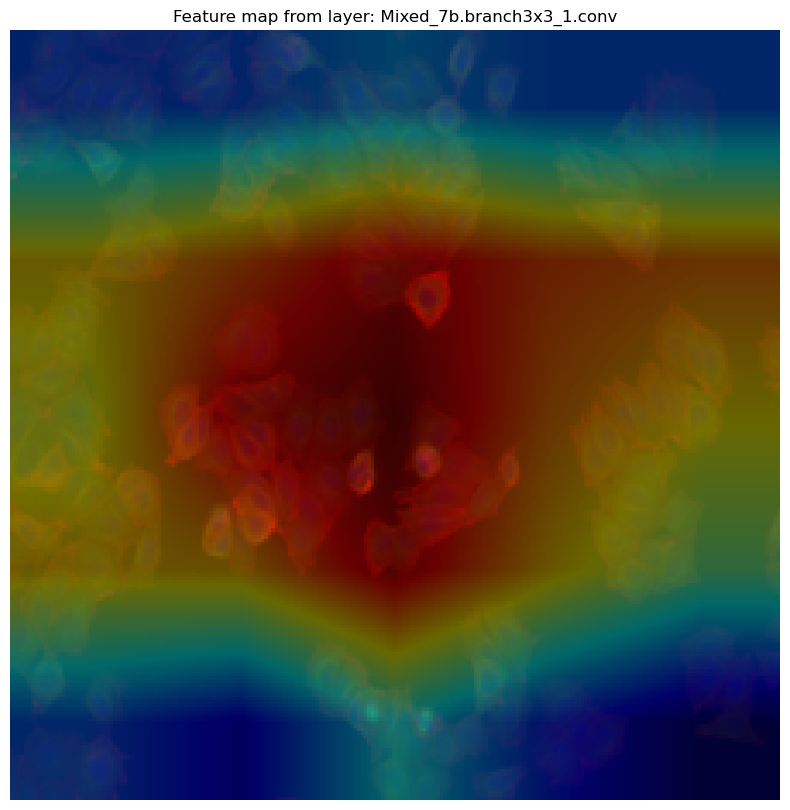

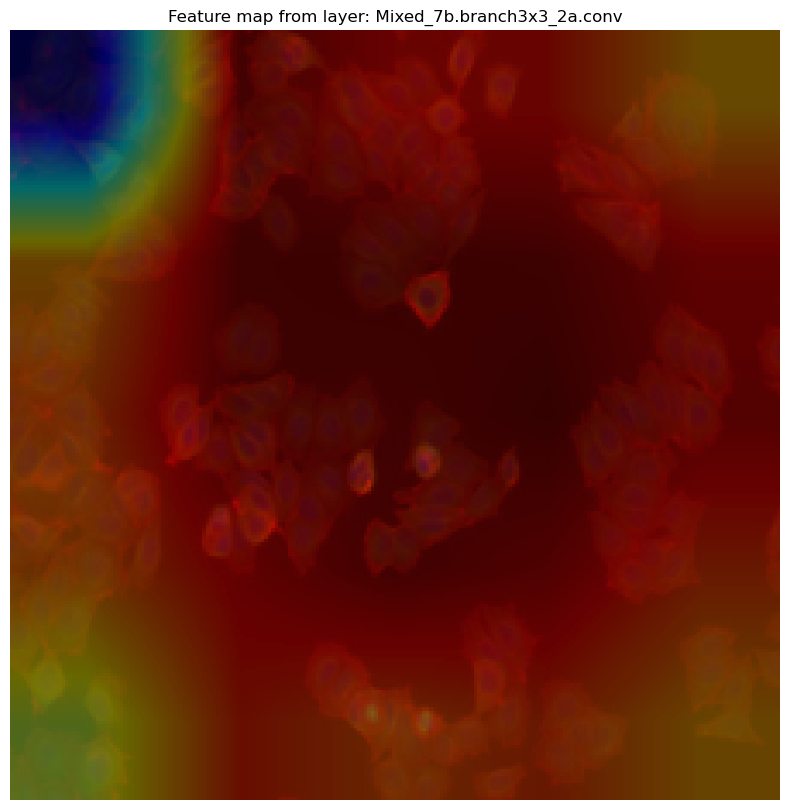

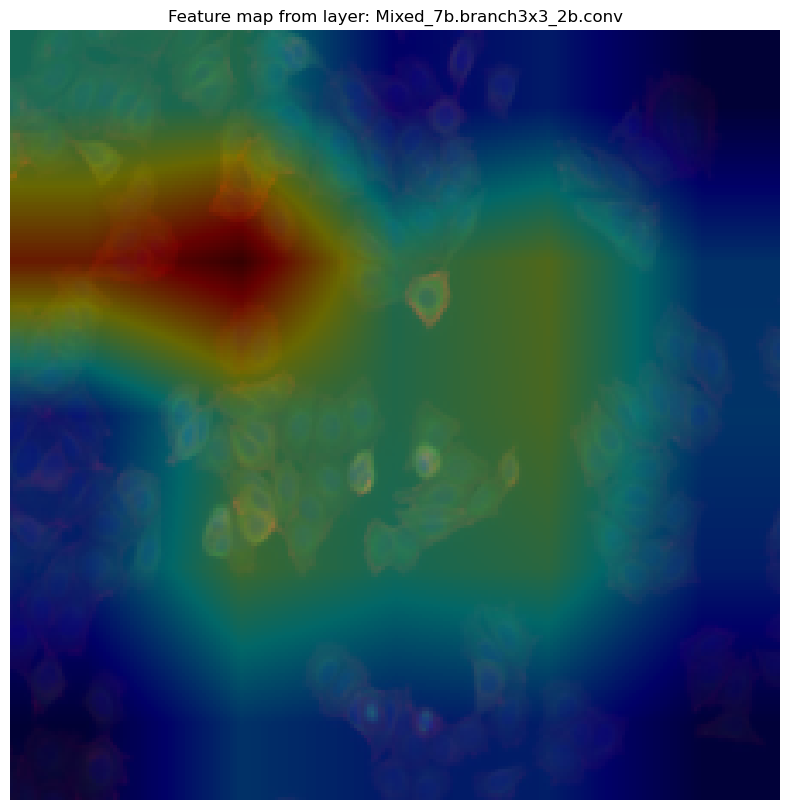

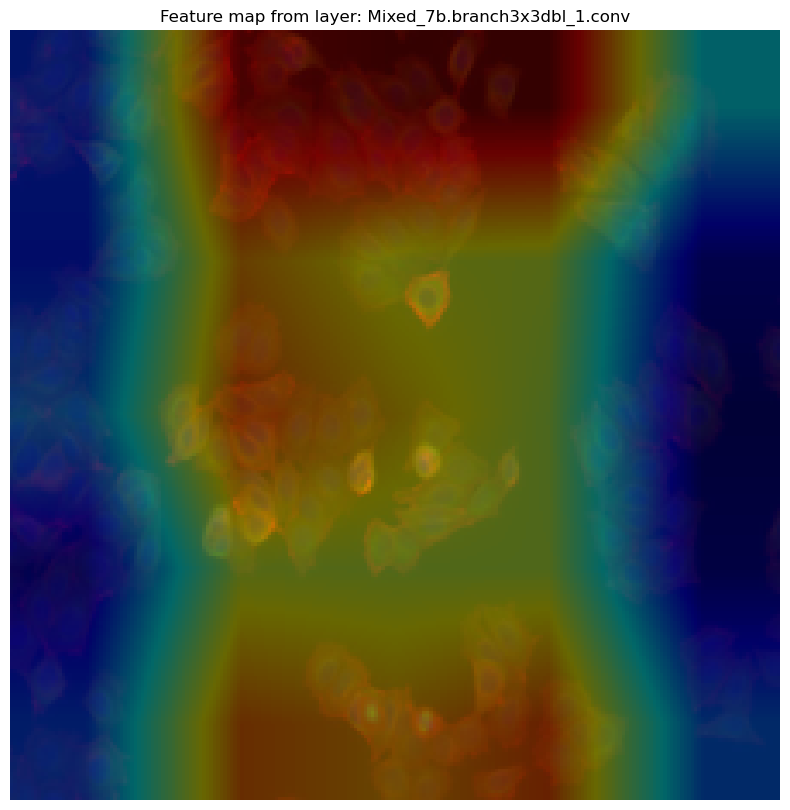

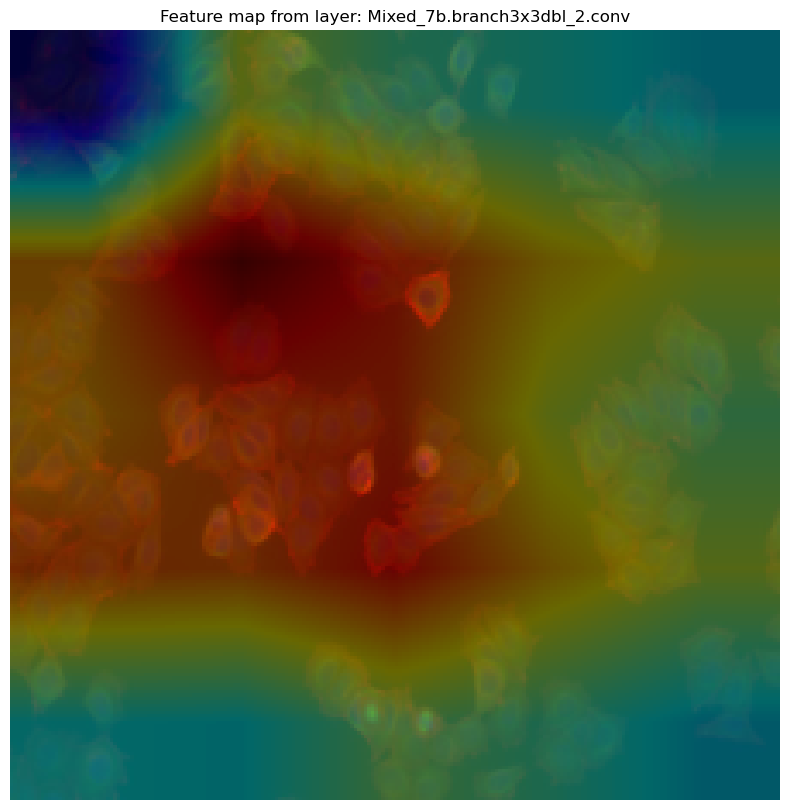

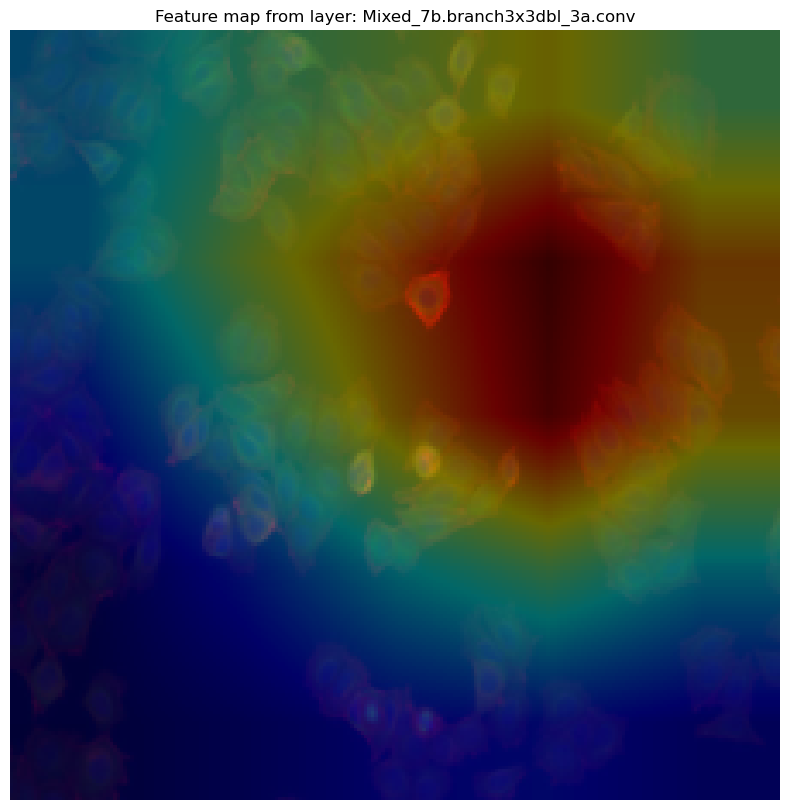

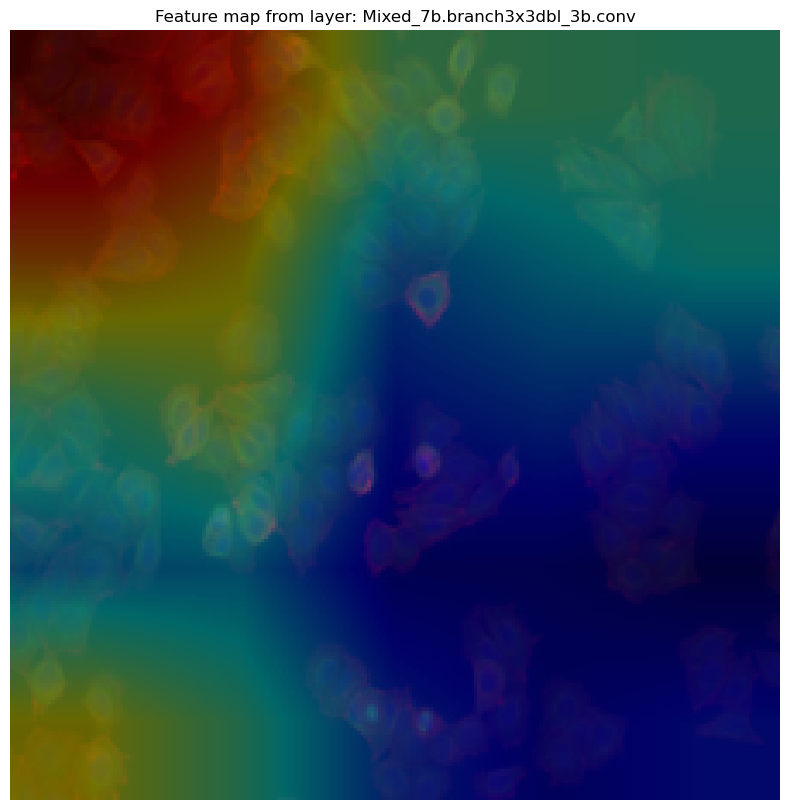

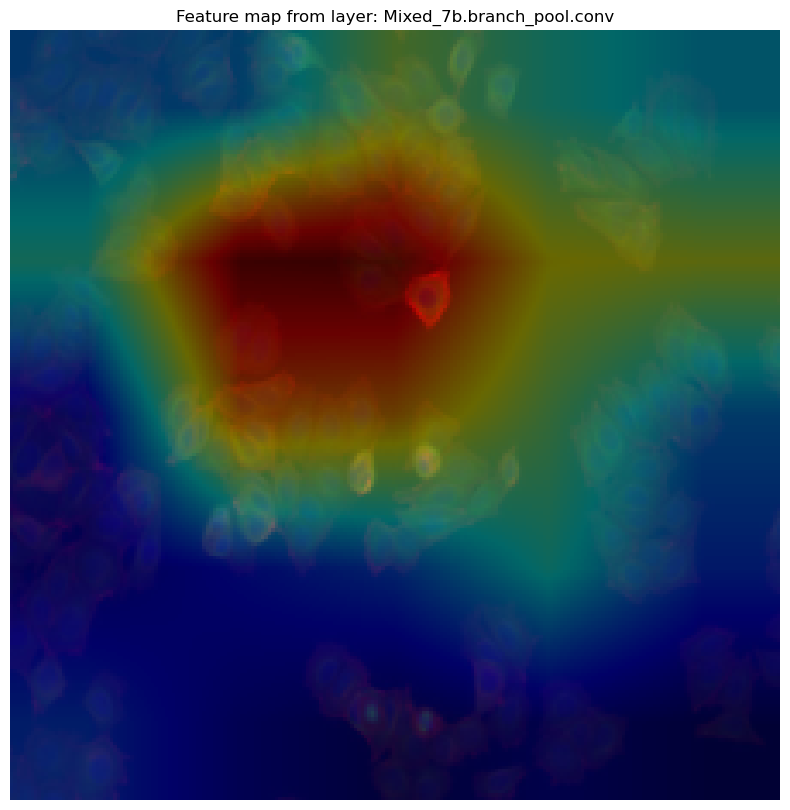

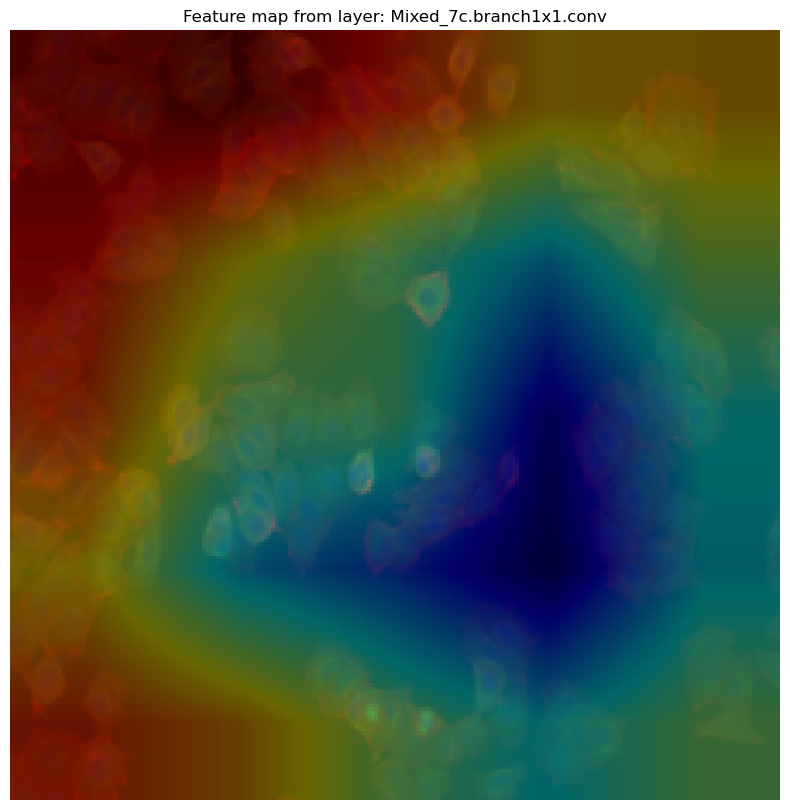

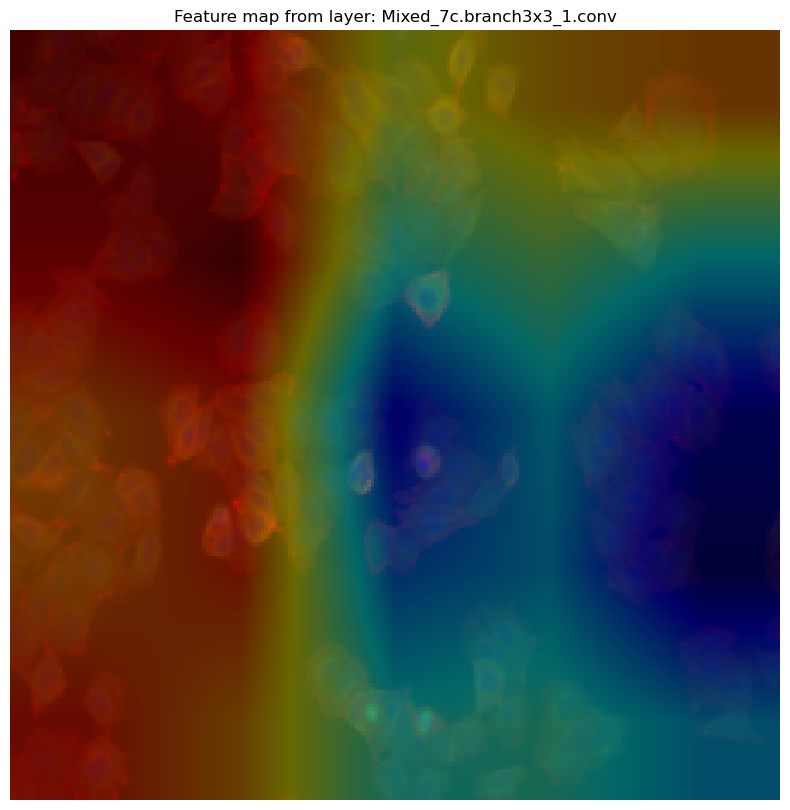

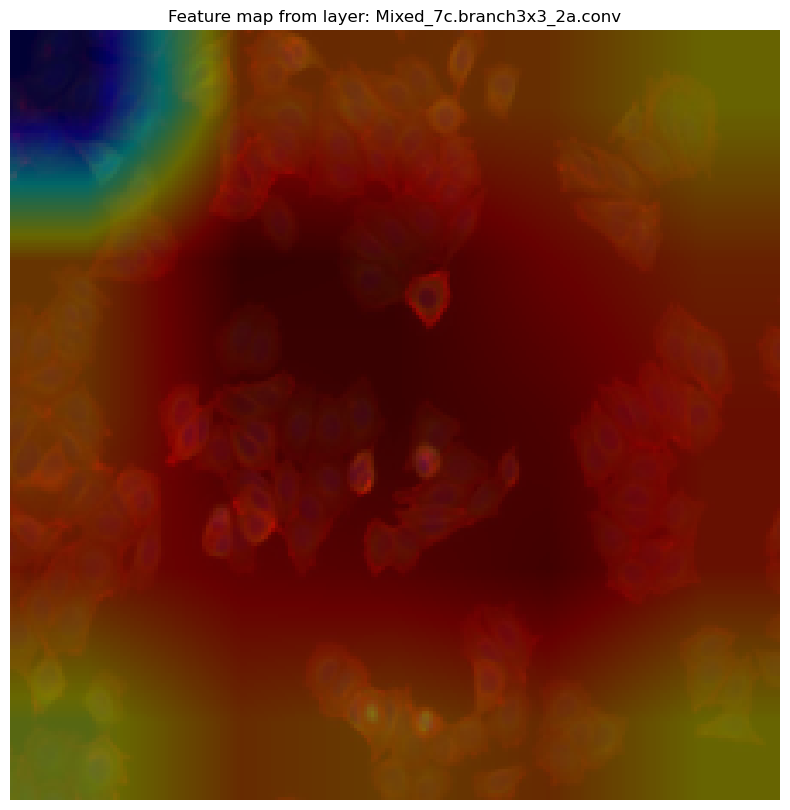

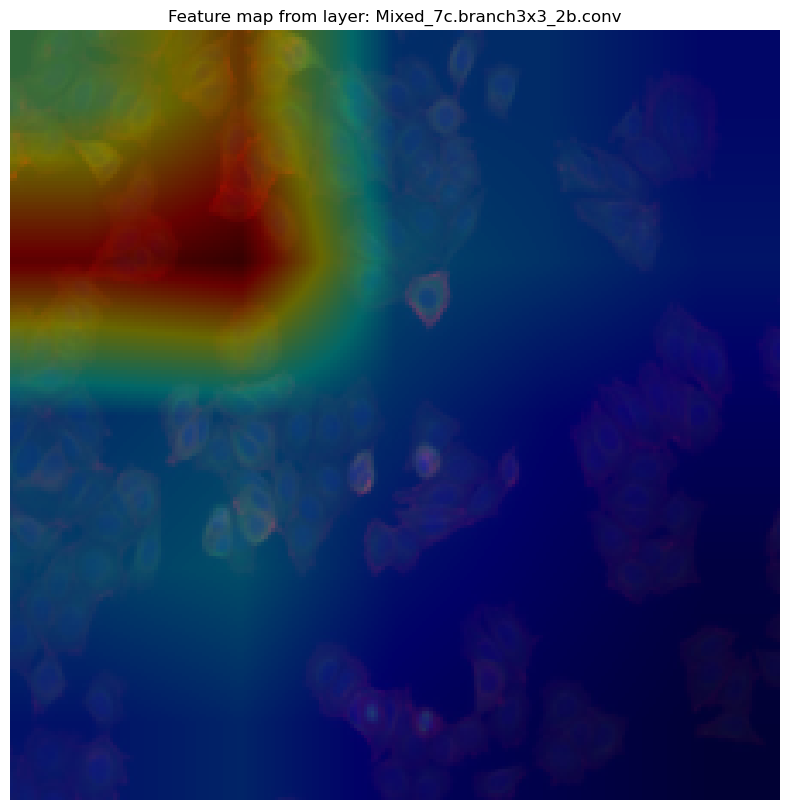

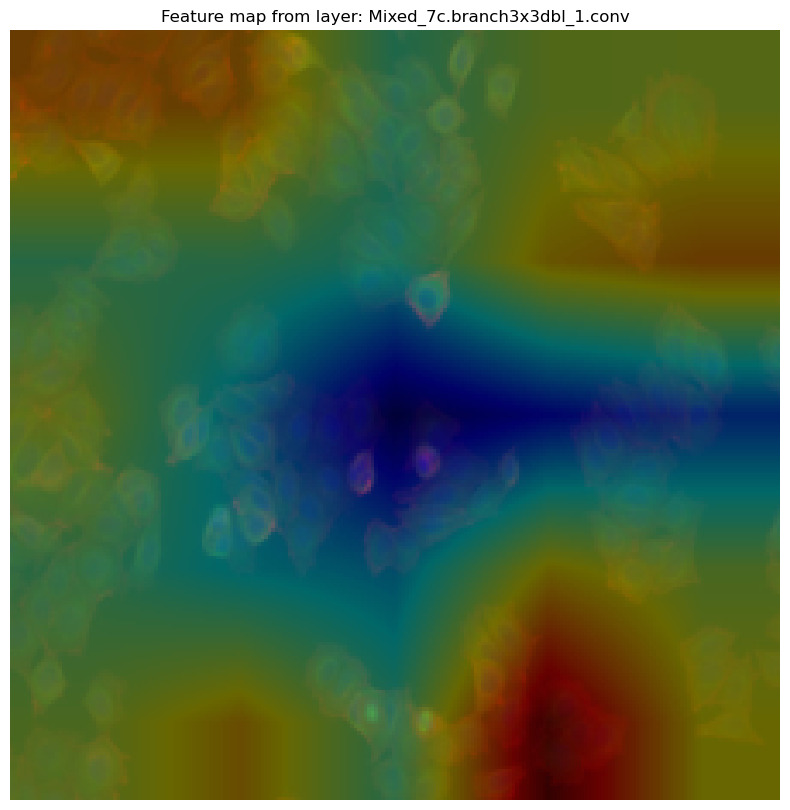

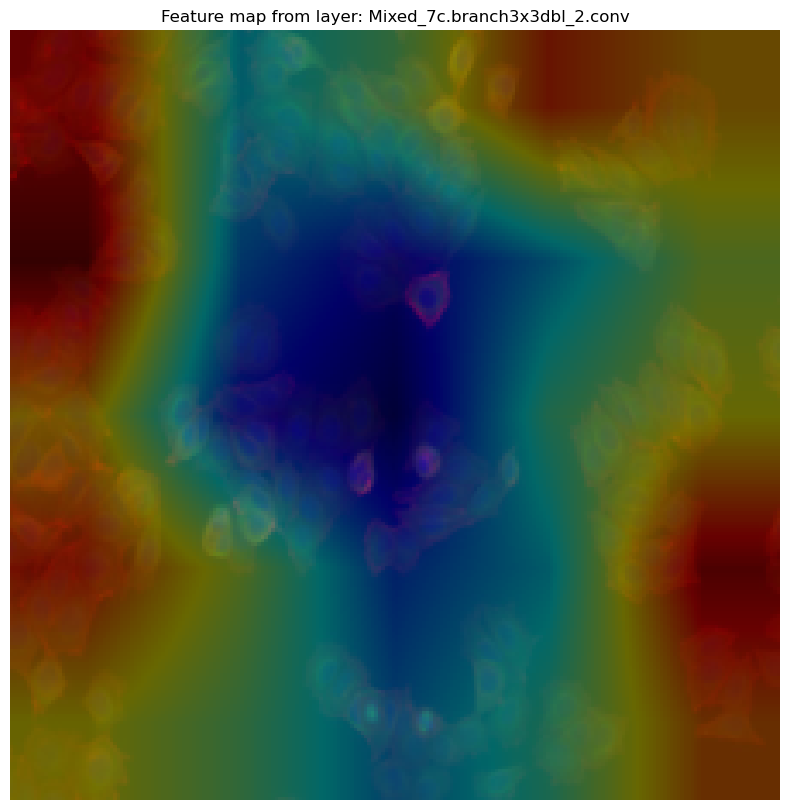

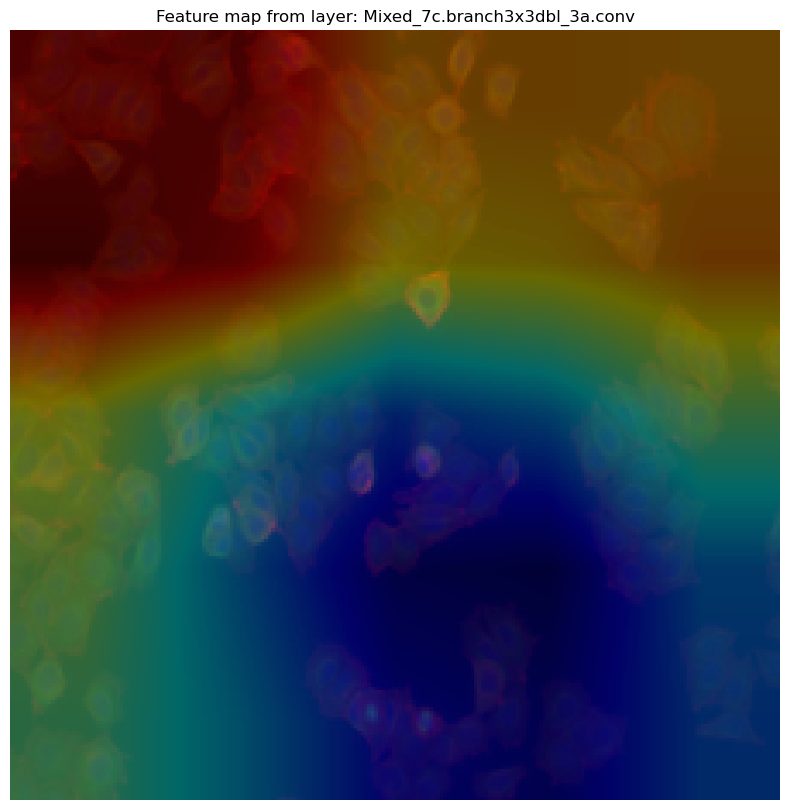

In [20]:
visualize_features("images/example_cell_img.jpeg", -16, save = True)

It now seems clear that layers "Mixed_7_b" and "Mixed_7_c" do not detect features that are specific to our cells, the same way they detect features that are specific to the cat or the lighthouse. Unfreezing the weights of these two layers and retraining them on our dataset therefore seems like a good idea to improve the training efficiency of our CNN. 